In [1]:
import sys

sys.path.append("..")
from core.DataLoader import (
    DataPreprocessor,
    DataConfig,
    LoadConfig,
    get_load_config_from_yaml,
)
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import yaml

MAX_JETS = 6
PLOTS_DIR = f"plots/compare_cross_attention_model_performance/"
CONFIG_PATH = "../config/workspace_config.yaml"

import os

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)
plt.rcParams.update({"font.size": 14})

load_config = get_load_config_from_yaml(CONFIG_PATH)

DataProcessor = DataPreprocessor(load_config)
with open(CONFIG_PATH, "r") as f:
    data_config = yaml.safe_load(f)

data_config = DataProcessor.load_from_npz(data_config["data_path"]["nominal"],max_events=1_000_000)
X_val, y_val = DataProcessor.get_data()

2025-12-01 10:33:31.396689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764581611.420922 2999784 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764581611.428884 2999784 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764581611.448584 2999784 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764581611.448609 2999784 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764581611.448612 2999784 computation_placer.cc:177] computation placer alr

In [2]:
import core.assignment_models as AssignmentModels
import core.evaluation as Evaluation
from core.reconstruction import GroundTruthReconstructor

reload(Evaluation)
reload(AssignmentModels)

ToponiumTransformer = AssignmentModels.FeatureConcatTransformer(data_config, name="ToponiumTransformer")
MODEL_DIR = f"models/toponium_transformer_HLF/"
ToponiumTransformer.load_model(MODEL_DIR + "model.keras")

Transformer = AssignmentModels.FeatureConcatTransformer(data_config, name="Transformer")
MODEL_DIR = f"models/assignment_transformer_HLF/"
MODEL_DIR = f"../models/FeatureConcatTransformer_d256_l6_h8/"
Transformer.load_model(MODEL_DIR + "model.keras")

MixedTransformer = AssignmentModels.FeatureConcatTransformer(data_config, name="ToponiumInfusedTransformer")
MODEL_DIR = f"models/mixed_model/"
MixedTransformer.load_model(MODEL_DIR + "model.keras")

CrossAttentionTransformer = AssignmentModels.CrossAttentionModel(data_config, name = "CrossAttentionModel")
MODEL_DIR = f"../models/CrossAttentionTransformer_d256_l10_h8/"
CrossAttentionTransformer.load_model(MODEL_DIR + "model.keras")

FeatureConcatTransformer is designed for classification tasks; regression targets will be ignored.


I0000 00:00:1764581689.144003 2999784 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:65:00.0, compute capability: 6.0


Model loaded from models/toponium_transformer_HLF/model.keras
Training history loaded from models/toponium_transformer_HLF/model_history.npz
FeatureConcatTransformer is designed for classification tasks; regression targets will be ignored.
Model loaded from ../models/FeatureConcatTransformer_d256_l6_h8/model.keras
Training history loaded from ../models/FeatureConcatTransformer_d256_l6_h8/model_history.npz
FeatureConcatTransformer is designed for classification tasks; regression targets will be ignored.
Model loaded from models/mixed_model/model.keras
Model loaded from ../models/CrossAttentionTransformer_d256_l10_h8/model.keras
Training history loaded from ../models/CrossAttentionTransformer_d256_l10_h8/model_history.npz


In [3]:
evaluator = Evaluation.ReconstructionEvaluator(
    [
        #ToponiumTransformer,
        Transformer,
        #MixedTransformer,
        CrossAttentionTransformer,
        #GroundTruthReconstructor(data_config, name=r"Perfect Assignment", use_nu_flows=True),
    ],
    X_val,
    y_val,
)

I0000 00:00:1764581697.400568 3001355 service.cc:152] XLA service 0x7faad0009dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764581697.400594 3001355 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2025-12-01 10:34:57.458099: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatTransformerModel_1/met_input_transform_1/assert_equal_1/Assert/Assert
2025-12-01 10:34:57.485320: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764581697.766274 3001355 cuda_dnn.cc:529] Loaded cuDNN version 91500
I0000 00:00:1764581698.752866 3001355 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-12-01 10:35:33.401866: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring

## Accuracy Plots


Computing bootstrap confidence intervals...
Transformer: 0.8069 [0.8062, 0.8077]
CrossAttentionModel: 0.8047 [0.8038, 0.8055]


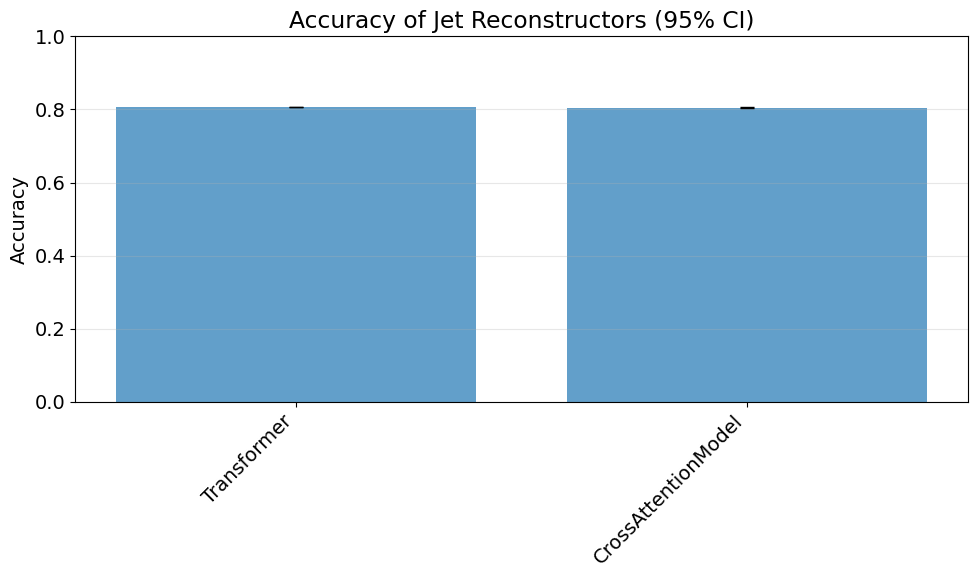

In [4]:
fig, ax = evaluator.plot_all_accuracies()
fig.savefig(PLOTS_DIR + "all_accuracies.pdf")


Computing bootstrap confidence intervals...
Transformer: 0.9546 [0.9543, 0.9550]
CrossAttentionModel: 0.9563 [0.9560, 0.9567]


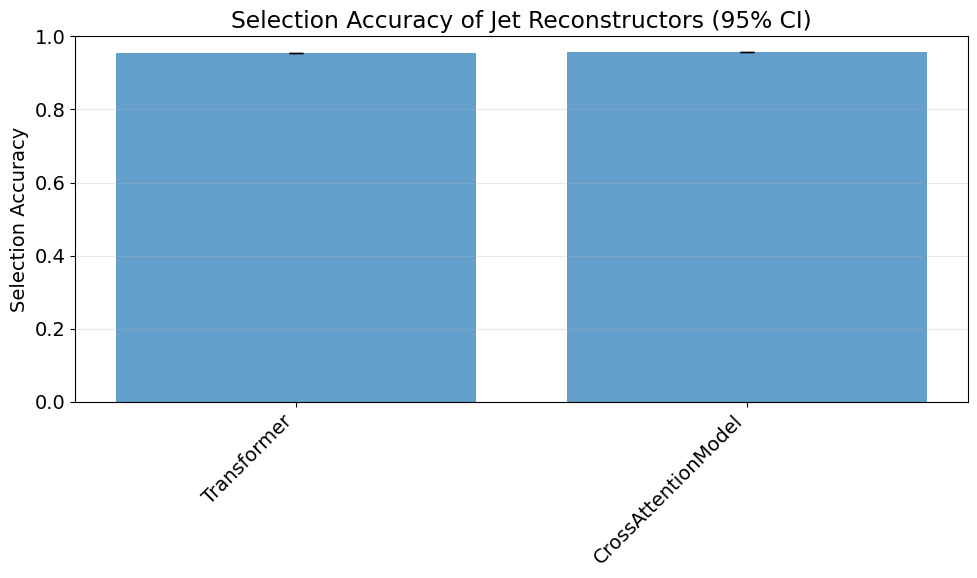

In [5]:
fig, ax = evaluator.plot_all_selection_accuracies()
fig.savefig(PLOTS_DIR + "all_selection_accuracies.pdf")


Computing binned accuracy for N_jets...


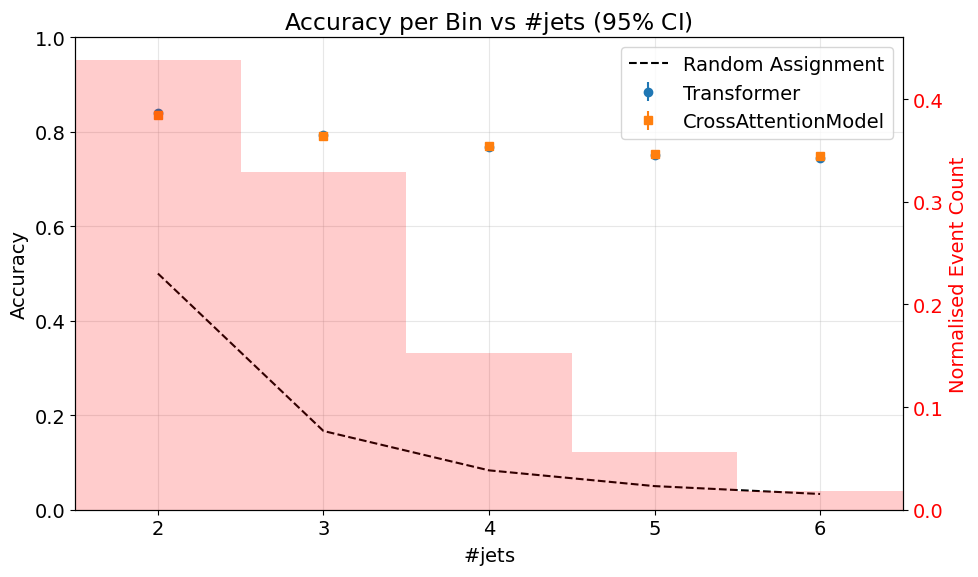

In [6]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="N_jets",
    fancy_feature_label=r"$\# \text{jets}$",
    xlims=(2, data_config.max_jets + 1),
    bins=data_config.max_jets - 1,
    n_bootstrap=10,
)
ax.set_xticks([i + 0.5 for i in range(2, data_config.max_jets + 1)])
ax.set_xticklabels([i for i in range(2, data_config.max_jets + 1)])
fig.savefig(PLOTS_DIR + "binned_accuracy_N_jets.pdf")


Computing binned accuracy for truth_ttbar_mass...


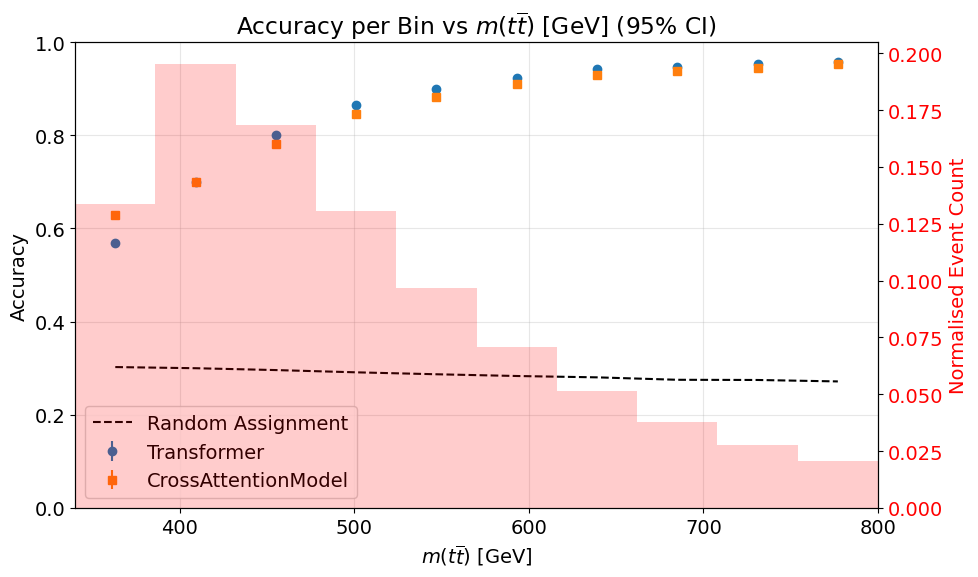

In [7]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_mass.pdf")


Computing binned accuracy for truth_ttbar_mass...


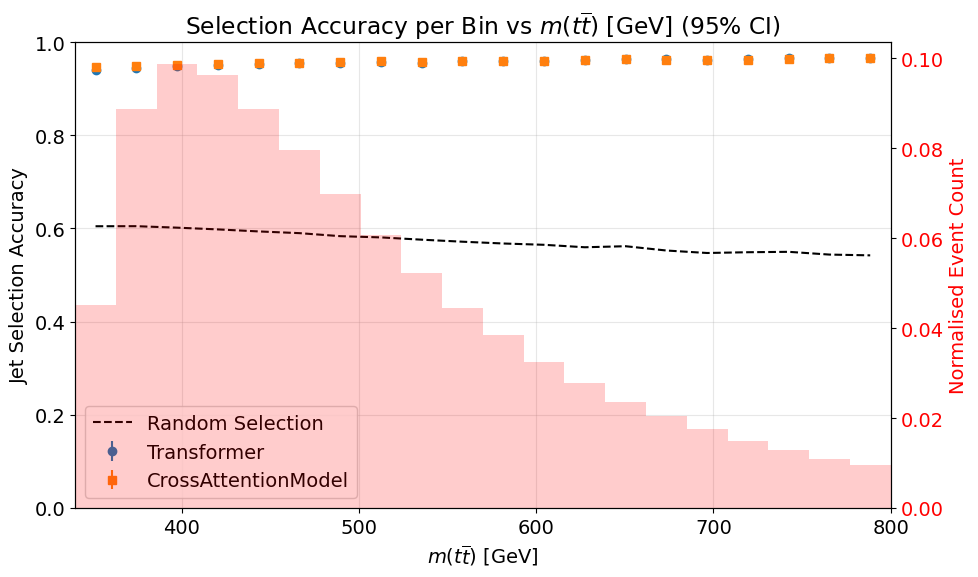

In [8]:
fig, ax = evaluator.plot_binned_selection_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)

fig.savefig(PLOTS_DIR + "binned_selecton_accuracy_ttbar_mass_comparison.pdf")


Computing binned accuracy for truth_ttbar_pt...


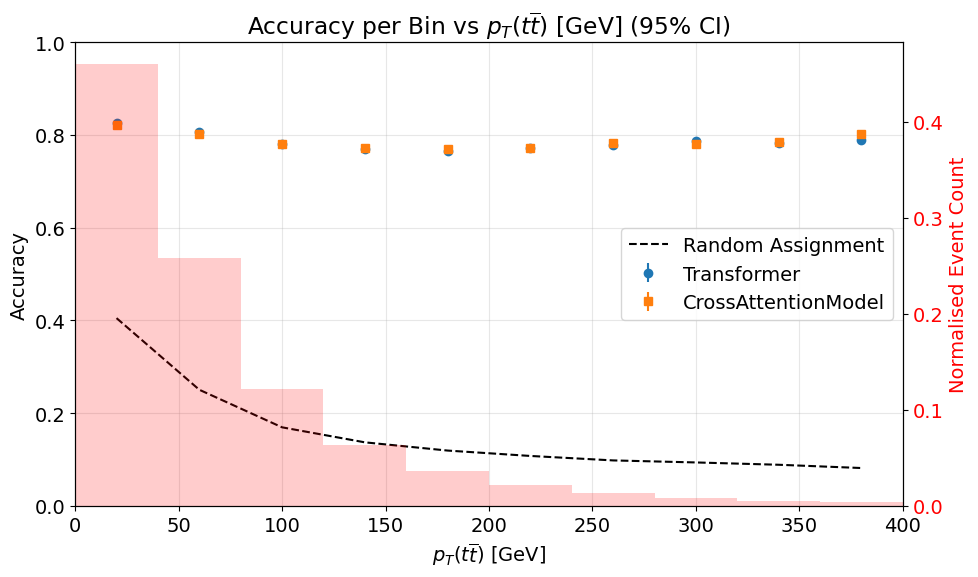

In [9]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_pt",
    fancy_feature_label=r"$p_T(t\overline{t})$ [GeV]",
    xlims=(0, 400e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(0, 400e3)

fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_pT.pdf")


Computing binned accuracy for dR_l1l2...


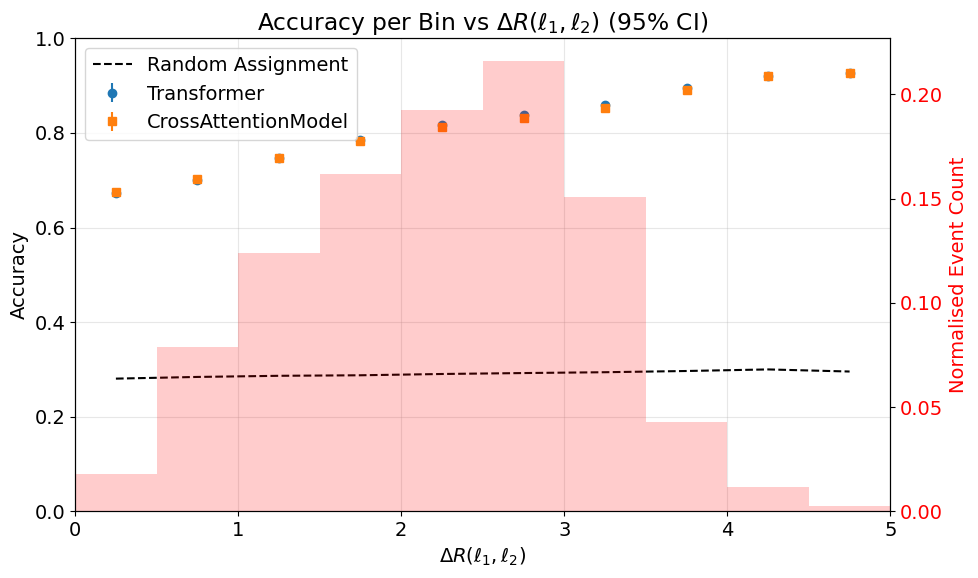

In [10]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="dR_l1l2",
    fancy_feature_label=r"$\Delta R(\ell_1,\ell_2)$",
    xlims=(0, 5),
    bins=10,
    n_bootstrap=10,
)
ax.set_xlim(0, 5)
fig.savefig(PLOTS_DIR + "binned_accuracy_dR_l1l2.pdf")


Computing binned Relative $m(t)$ Resolution for truth_ttbar_mass...


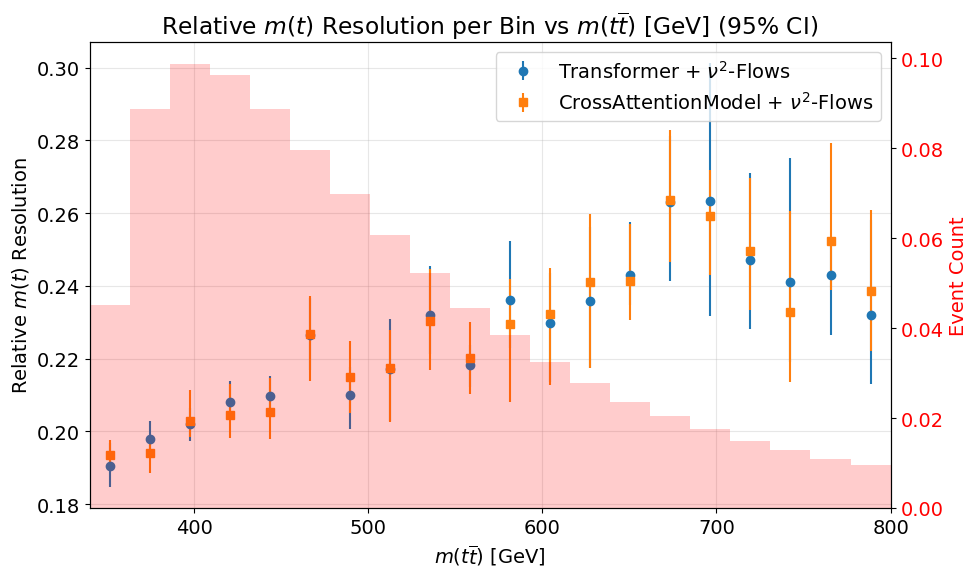

In [11]:
fig, ax = evaluator.plot_binned_top_mass_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "top_mass_resolution_comparison.pdf")

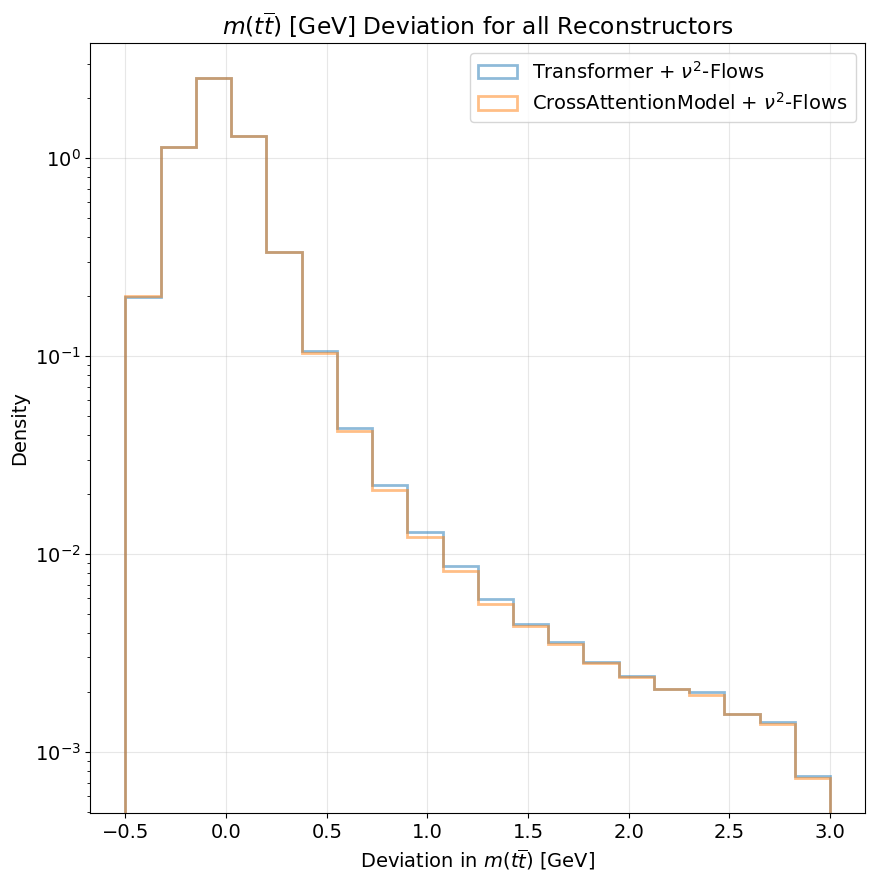

In [12]:
fig, ax = evaluator.plot_ttbar_mass_deviation_distribution(bins = 20, xlims = (-0.5, 3))
ax.set_yscale("log")
fig.savefig(f"{PLOTS_DIR}/ttbar_mass_deviation_distribution.png", bbox_inches="tight")

## Resolution Plots


Computing binned $\cos(\theta_{hel})$ Resolution for truth_ttbar_mass...


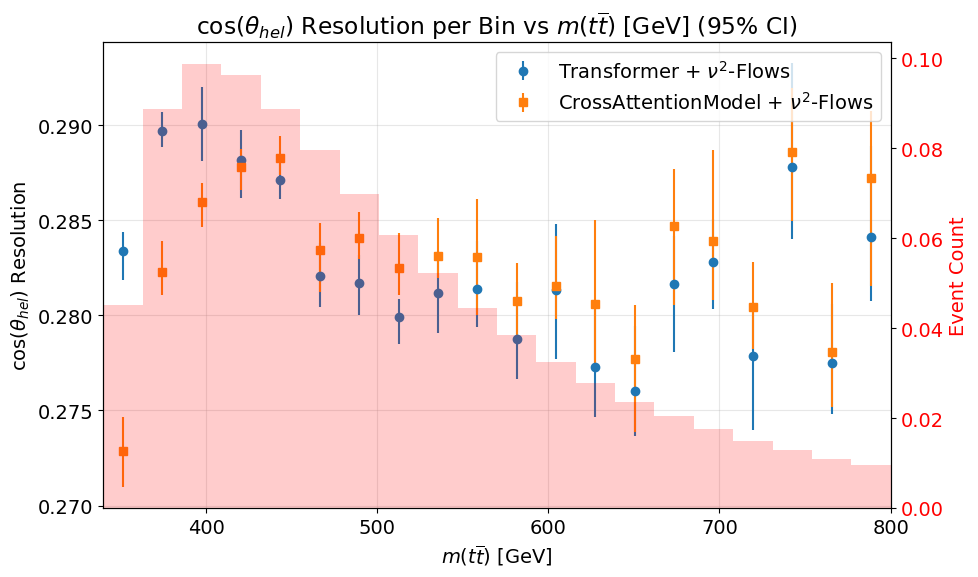

In [13]:
fig, ax = evaluator.plot_binned_c_hel_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "c_hel_resolution_comparison.pdf")


Computing binned $\cos(\theta_{han})$ Resolution for truth_ttbar_mass...


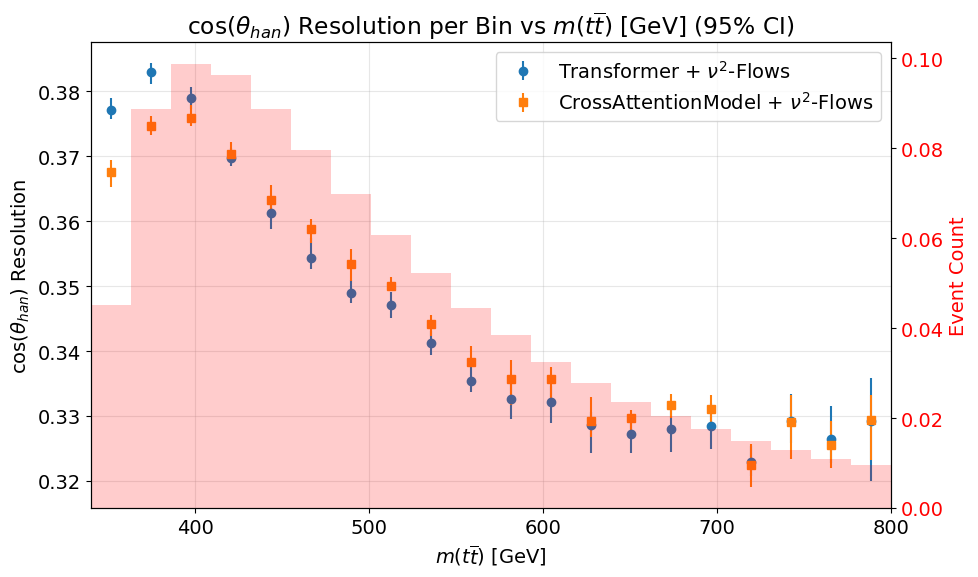

In [14]:
fig, ax = evaluator.plot_binned_c_han_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "c_han_resolution_comparison.pdf")


Computing binned Relative $m(t\overline{t})$ Resolution for truth_ttbar_mass...


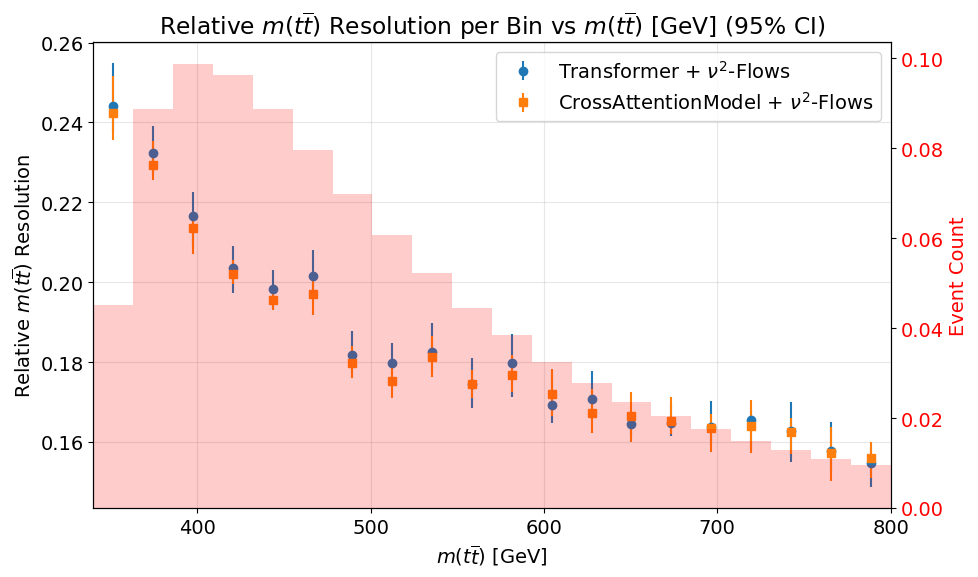

In [15]:
fig, ax = evaluator.plot_binned_ttbar_mass_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "ttbar_mass_resolution_comparison.pdf")

## Mass Resolution and Deviation Plots


Computing binned Mean Relative $m(t)$ Deviation for truth_ttbar_mass...


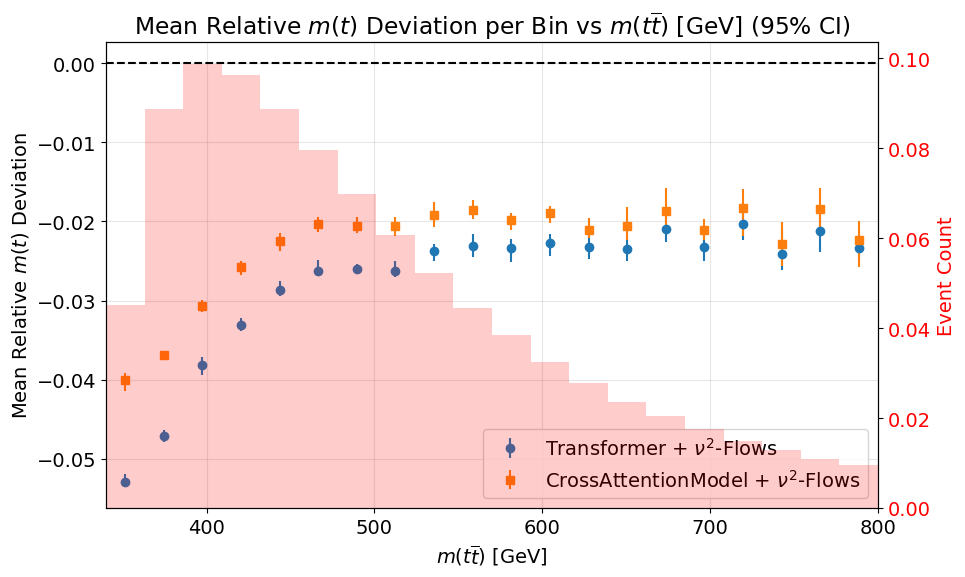

In [16]:
fig, ax = evaluator.plot_binned_top_mass_deviation(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.axhline(0, color="black", linestyle="--")
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "top_mass_deviation_comparison.pdf")


Computing binned Mean Relative $m(t\overline{t})$ Deviation for truth_ttbar_mass...


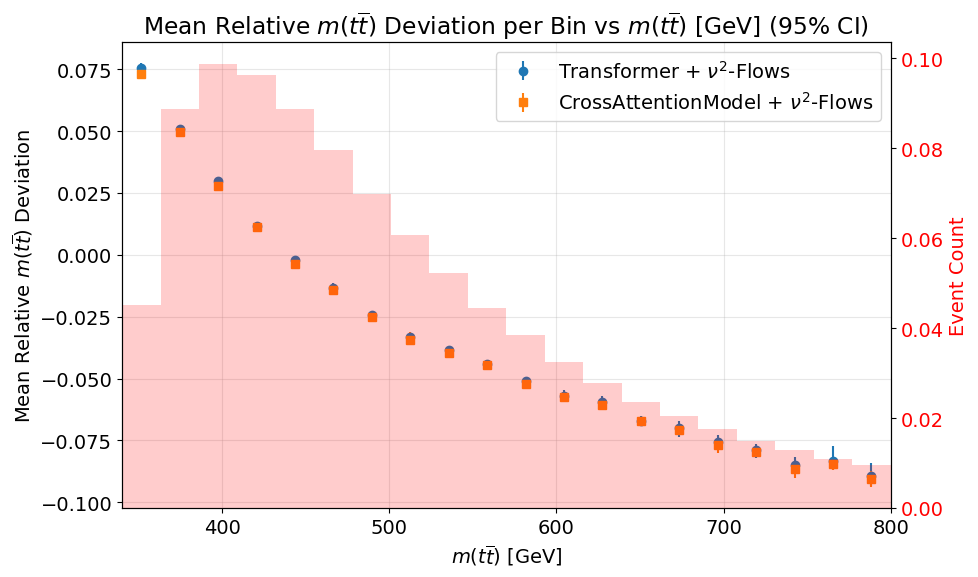

In [17]:
fig, ax = evaluator.plot_binned_ttbar_mass_deviation(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "ttbar_mass_deviation_comparison.pdf")


Computing binned accuracy for truth_ttbar_mass...


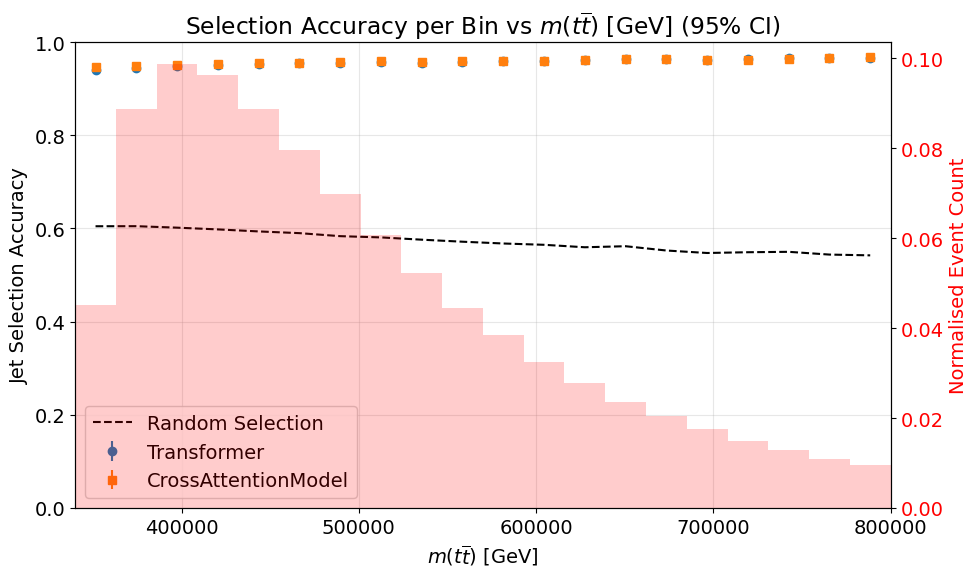

In [18]:
evaluator.plot_binned_selection_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
)
fig.savefig(PLOTS_DIR + "binned_selection_accuracy_ttbar_mass.pdf")

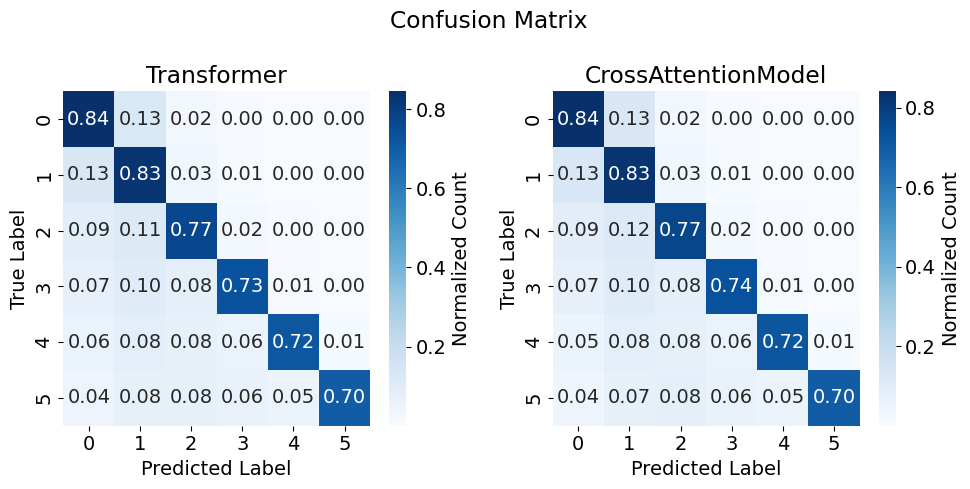

: 

In [ ]:
fig, ax = evaluator.plot_confusion_matrices()
fig.savefig(PLOTS_DIR + "confusion_matrices.pdf")